# Training the SPOCK model

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
# from simsetup import get_sim
# from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

Start by loading the training data

In [31]:
#load datapath for clean training data
datapath = '../../cleanData/csvs/resonant/'

dataset = pd.read_csv(datapath+'CleanResTrainingData.csv')
#remove junk columns
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

We can then split the data into training and testing sets, note, we will remove systems that go unstable in 1e4 orbits from the testing set

In [65]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits
    test = test.drop(test[test['instability_time']<=1e4].index)
    return train[features], train['Stable'], test[features], test['Stable']

In [66]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

trainX, trainY, testX, testY = train_test(dataset, features)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

# Tuning hyperparameter
We can determine the idea values for the different hyperparameters.

We will start by creating and testing a collection of models that have randomly selected hyperparameters

scale_pos_weight is a hyperparameter used to account for skewed training data, it does this by weighting false positives and negatives differently. A typical value can be obtained by dividing your negative outcomes in your training data by your positive outcomes.

In [67]:
trainingBalance = trainY.value_counts()[False]/trainY.value_counts()[True]

We can then establish the different parameter space that we will be testing different hyperparameter values within.

In [68]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(30)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 75,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0,
                            scale_pos_weight = trainingBalance)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


We can then create and evaluate the different trials

In [69]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                 
0.9289994488194958                                     
ERROR                                                  
0.002314415074498772                                   
SCORE:                                                                            
0.9287868591672727                                                                
ERROR                                                                             
0.002214241384532999                                                              
SCORE:                                                                            
0.9338275322363888                                                                
ERROR                                                                             
0.00260143546370993                                                               
SCORE:                                                                            
0.9279798259767592           

We can not determine what values for hyperparameters will be ideal. We can do this by plotting how AUC changes as we alter each hyperparameter.

Here we will find that an optimal max_depth would be 15, which gives the best performance without over fitting.

Text(0, 0.5, 'CV AUC')

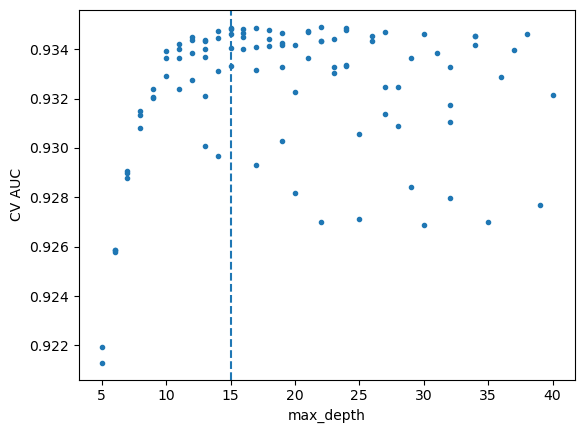

In [75]:
depths = trials.vals['x_max_depth']
min_childs = trials.vals['x_min_child']
subsample = trials.vals['x_subsample']
aucs = np.array([1-x['loss'] for x in trials.results])
fig, ax = plt.subplots()
ax.plot(depths, aucs, '.')
ax.axvline(15, linestyle='--')
ax.set_xlabel('max_depth')
ax.set_ylabel('CV AUC')

Here we will find that an optimal min_childs would be 10, which gives the best performance without over fitting.

Text(0, 0.5, 'CV AUC')

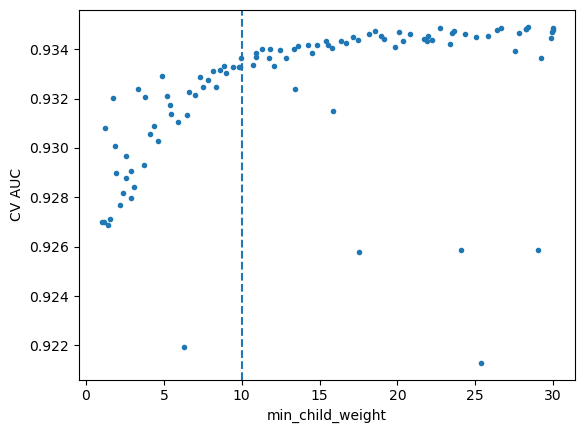

In [71]:
fig, ax = plt.subplots()
ax.plot(min_childs, aucs, '.')
ax.axvline(10, linestyle='--')
ax.set_xlabel('min_child_weight')
ax.set_ylabel('CV AUC')

Here we will find that an optimal subsample value would be 0.95 due to a malignly higher concentration of high preforming models. Most values seem to give good enough results.

Text(0, 0.5, 'CV AUC')

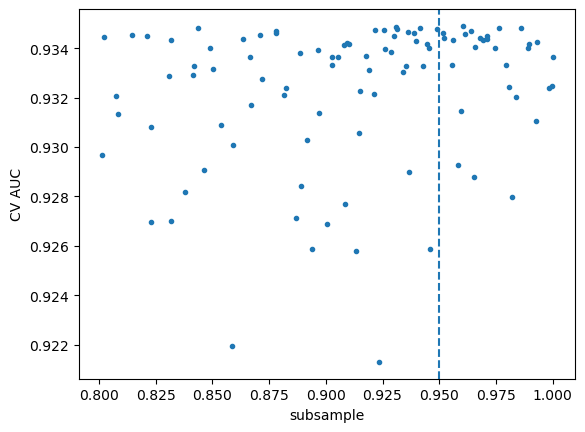

In [72]:
fig, ax = plt.subplots()
ax.plot(subsample, aucs, '.')
ax.axvline(.95, linestyle='--')
ax.set_xlabel('subsample')
ax.set_ylabel('CV AUC')

We can now determine, with these new values, what the optimal number of n_estimators is.

In [73]:
model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 10,
                         scale_pos_weight = trainingBalance)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=400)

[0]	train-auc:0.95262+0.00061	test-auc:0.92115+0.00207
[1]	train-auc:0.96026+0.00064	test-auc:0.92822+0.00232
[2]	train-auc:0.96310+0.00106	test-auc:0.93078+0.00225
[3]	train-auc:0.96515+0.00083	test-auc:0.93309+0.00182
[4]	train-auc:0.96647+0.00081	test-auc:0.93398+0.00220
[5]	train-auc:0.96753+0.00071	test-auc:0.93473+0.00213
[6]	train-auc:0.96858+0.00063	test-auc:0.93530+0.00224
[7]	train-auc:0.96957+0.00052	test-auc:0.93582+0.00234
[8]	train-auc:0.97032+0.00053	test-auc:0.93637+0.00234
[9]	train-auc:0.97098+0.00049	test-auc:0.93669+0.00222
[10]	train-auc:0.97162+0.00044	test-auc:0.93701+0.00227
[11]	train-auc:0.97224+0.00041	test-auc:0.93733+0.00226
[12]	train-auc:0.97278+0.00039	test-auc:0.93759+0.00222
[13]	train-auc:0.97331+0.00040	test-auc:0.93773+0.00224
[14]	train-auc:0.97384+0.00034	test-auc:0.93798+0.00219
[15]	train-auc:0.97435+0.00031	test-auc:0.93827+0.00213
[16]	train-auc:0.97485+0.00029	test-auc:0.93853+0.00217
[17]	train-auc:0.97532+0.00029	test-auc:0.93875+0.00210
[1

Here we will find that an optimal number of estimators would be about 125.

Text(0, 0.5, 'CV AUC score')

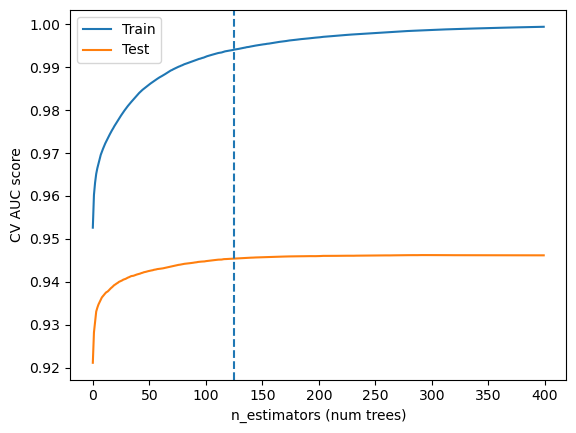

In [77]:
n_estimators = 125
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

# SPOCK

We can now train the final spock model

In [94]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = sklearn.metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [100]:
model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 10,
                         n_estimators = 125,
                         scale_pos_weight=trainingBalance)

In [101]:
model.fit(trainX,trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=125, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Text(0.5, 1.0, 'ROC curve (AUC = 0.948)')

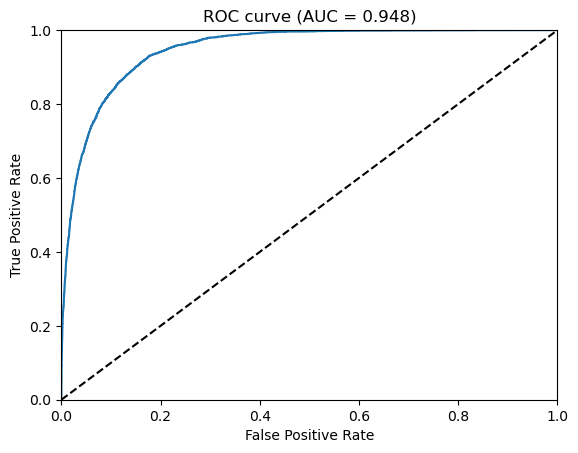

In [102]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [115]:
import os
print(os.getcwd())


/home/ethadhani/spockUpdate/train_models


In [117]:
model.save_model('../spock/models/spock.bin')